In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [10]:
# DownLoad train data
train_data = datasets.FashionMNIST(
    root="data", # data is stored
    train=True,
    download=True,
    transform=ToTensor(),
)

# DownLoad test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [11]:
batch_size = 64 # 每次处理多少张图片

train_datloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]:{X.shape}") # batch_size 通道数 尺寸
    print(f"Shape of y:{y.shape} {y.dtype}") 
    break

Shape of X [N, C, H, W]:torch.Size([64, 1, 28, 28])
Shape of y:torch.Size([64]) torch.int64


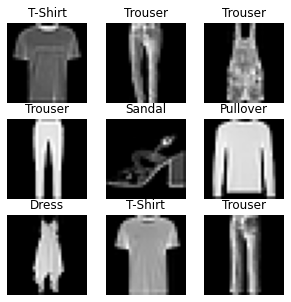

In [17]:
## 打印图片
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(5, 5))
cols,rows = 3,3
for i in range(1,cols * rows + 1):
    # 随机整数 low=0,high=len,size=生成矩阵的形状
    sample_index = torch.randint(len(train_data) , size=(1,)).item()
    img, label = train_data[sample_index]
    figure.add_subplot(rows, cols , i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

* [需要创建自己的数据集](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

In [19]:
# 创建模型
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [24]:
# Define model
class NeurakNetwork(nn.Module):
    def __init__(self):
        super(NeurakNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logites = self.linear_relu_stack(x)
        return logites

In [25]:
model = NeurakNetwork().to(device)
print(model)

NeurakNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


* flatten 扁平化解析
    * 将数据降维度
    * 参数解析：
        * start_dim：开始flatten的维度
        * end_dim：结束flatten的维度
    * 默认降为一维
      

* flatten测试

In [26]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [27]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [28]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [29]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeurakNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0087, -0.0189, -0.0317,  ..., -0.0070,  0.0140,  0.0148],
        [-0.0277, -0.0183,  0.0235,  ...,  0.0077, -0.0354,  0.0328]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0237, -0.0346], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-3.2562e-02, -2.0867e-03, -1.1998e-02,  ..., -1.5243e-02,
          2.1832e-02,  8.9984e-06],
        [ 4.2591e-02,  2.1716e-02,  1.5062e-02,  ...,  2.9563e-02,
      

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [42]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X) #预测值
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        # to reset the gradients of model parameters. 
        # Gradients by default add up; to prevent double-counting, 
        # we explicitly zero them at each iteration.
        loss.backward() # 反向传播来存储梯度
        optimizer.step() # adjust parameters
        
        if batch % 100 ==0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [43]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_bacthes = len(dataloader)
    model.eval() # 启用 Batch Normalization 和 Dropout
    test_loss, correct = 0, 0 # 损失和精度
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_bacthes
    correct /= size 
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [44]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train(train_datloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 2.315049 [    0/60000]
loss: 2.301201 [ 6400/60000]
loss: 2.282977 [12800/60000]
loss: 2.272082 [19200/60000]
loss: 2.260510 [25600/60000]
loss: 2.243114 [32000/60000]
loss: 2.253922 [38400/60000]
loss: 2.224294 [44800/60000]
loss: 2.221807 [51200/60000]
loss: 2.190649 [57600/60000]
Test Error:
 Accuracy: 39.9%, Avg loss: 2.185046 

Epoch 2
---------------------------
loss: 2.200382 [    0/60000]
loss: 2.190747 [ 6400/60000]
loss: 2.142898 [12800/60000]
loss: 2.148067 [19200/60000]
loss: 2.106621 [25600/60000]
loss: 2.064809 [32000/60000]
loss: 2.091447 [38400/60000]
loss: 2.022743 [44800/60000]
loss: 2.020860 [51200/60000]
loss: 1.955391 [57600/60000]
Test Error:
 Accuracy: 46.9%, Avg loss: 1.953333 

Epoch 3
---------------------------
loss: 1.991677 [    0/60000]
loss: 1.962671 [ 6400/60000]
loss: 1.858740 [12800/60000]
loss: 1.878536 [19200/60000]
loss: 1.781860 [25600/60000]
loss: 1.743545 [32000/60000]
loss: 1.762302 [38400/60000]
loss: 1

In [45]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [46]:
# loading models
model = NeurakNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [48]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"
